100%|██████████| 4.17M/4.17M [00:03<00:00, 1.14MB/s]
/var/folders/z0/pybv3yv908z3bszzq587509r0000gn/T/ipykernel_17740/900993217.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[i].set_title(f"Label: {int(label)}")


Train size: 4708 | Test size: 624


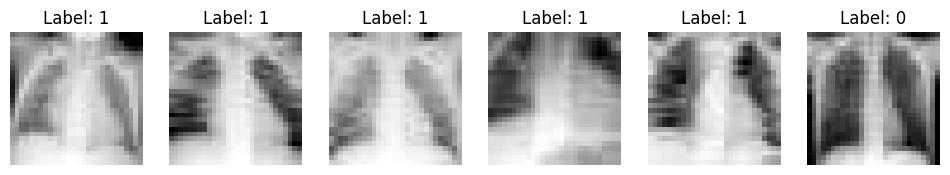

Epoch 1/3 - Loss: 0.4016
Epoch 2/3 - Loss: 0.2490
Epoch 3/3 - Loss: 0.2218
✅ Accuracy on test set: 86.70%


/var/folders/z0/pybv3yv908z3bszzq587509r0000gn/T/ipykernel_17740/900993217.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True Label: {int(sample_label)} (0=Normal, 1=Pneumonia)")


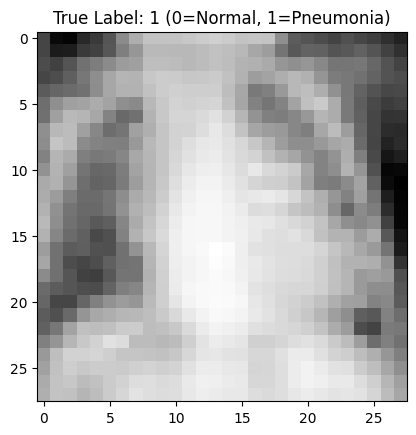

🤖 Predicted Label: 1


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt

from medmnist import PneumoniaMNIST
from torch.utils.data import DataLoader

# Transform to Tensor + Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Download train and test sets
train_dataset = PneumoniaMNIST(split='train', download=True, transform=transform)
test_dataset = PneumoniaMNIST(split='test', download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train size: {len(train_dataset)} | Test size: {len(test_dataset)}")

# Show 6 random samples
fig, axes = plt.subplots(1, 6, figsize=(12, 3))
for i in range(6):
    img, label = train_dataset[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {int(label)}")
    axes[i].axis('off')
plt.show()

# 0 = Normal, 1 = Pneumonia

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 2)  # Binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 3  # keep it small for quick demo
for epoch in range(epochs):
    running_loss = 0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"✅ Accuracy on test set: {100 * correct / total:.2f}%")

sample_img, sample_label = test_dataset[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"True Label: {int(sample_label)} (0=Normal, 1=Pneumonia)")
plt.show()

model.eval()
with torch.no_grad():
    pred = model(sample_img.unsqueeze(0).to(device))
    predicted_label = torch.argmax(pred).item()
    print(f"🤖 Predicted Label: {predicted_label}")


In [1]:
!pip install medmnist torch torchvision matplotlib --quiet